In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

# 2 The Factors

In [2]:
factors = pd.read_excel('factor_pricing_data.xlsx',sheet_name='descriptions',index_col='Unnamed: 0')
factors = pd.read_excel('factor_pricing_data.xlsx',sheet_name='factors (excess returns)',index_col='Date')
factors.tail()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2022-04-30,-0.0946,-0.0040,0.0619,0.0363,0.0592,0.0489
2022-05-31,-0.0034,-0.0006,0.0841,0.0144,0.0398,0.0248
2022-06-30,-0.0843,0.0130,-0.0597,0.0185,-0.0470,0.0079
2022-07-31,0.0957,0.0187,-0.0410,0.0068,-0.0694,-0.0396
2022-08-31,-0.0378,0.0151,0.0031,-0.0480,0.0131,0.0209


## 2.1 
### Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare there univariate statistics.<br> • mean <br>• volatility <br> • Sharpe


In [3]:
def summaryStats(df):
    
    summary = pd.DataFrame(index = df.columns)
    
    summary['Mean'] = df.mean()*12
    summary['Volatility'] = df.std()*np.sqrt(12)
    summary['Sharpe Ratio'] = summary['Mean']/summary['Volatility']    
        
    return summary

#### Beginning - 1980

In [4]:
summaryStats(factors[:'1980'])

,Mean,Volatility,Sharpe Ratio
MKT,0.2029,0.203717,0.995990
SMB,0.0537,0.108821,0.493472
HML,-0.1987,0.117754,-1.687412
RMW,0.1078,0.073037,1.475957
CMA,-0.0977,0.076936,-1.269882
UMD,0.3078,0.234594,1.312054


#### 1981 - 2001

In [5]:
summaryStats(factors['1981':'2001'])

,Mean,Volatility,Sharpe Ratio
MKT,0.077257,0.157396,0.490847
SMB,0.001433,0.109694,0.013067
HML,0.063729,0.111276,0.572706
RMW,0.046910,0.091743,0.511312
CMA,0.053114,0.077273,0.687356
UMD,0.101686,0.145105,0.700775


#### 2002 - End

In [6]:
summaryStats(factors['2002':])

,Mean,Volatility,Sharpe Ratio
MKT,0.083289,0.153972,0.540933
SMB,0.021068,0.090137,0.233731
HML,0.001679,0.104507,0.016066
RMW,0.039702,0.074726,0.531296
CMA,0.019423,0.064240,0.302346
UMD,0.017032,0.158055,0.107762


## 2.2
### Based on the factor statistics above, answer the following. <br><br> (a) Does each factor have a positive risk premium (positive expected excess return)?

Since 1981, each factor displays a positive risk premium. Up to 1980, two factors (HML and CMA) had negative risk premia while the other factors had positive risk premia.

### (b) How have the factors performed since the time of the case, (2015-present)?


Market factor (MKT) continues to be the dominant factor with highest annualized returns.  Profitability (RMW) is the next best factor generating healthy mean returns. Other factors have not performed so well but have all been positive. Value (HML) factor returns have been negligible. 

## 2.3
### Report the correlation matrix across the six factors.

<AxesSubplot:>

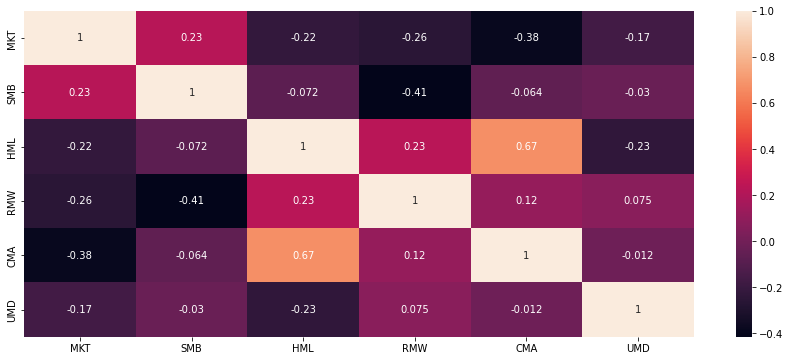

In [7]:
corr = factors.corr()
sns.heatmap(corr,annot=True)

### (a) Does the construction method succeed in keeping correlations small?

In general, yes the construction method does succeed in keeping correlations small.

Notably, the correlations between MKT (Market) and CMA (Investment) factors, HML (value) and UMD (Momentum) factors, and between SMB (size) and RMW (Profitability) factors has been negatve which looks attractive from a risk minimization perspective.

The correlation between HML (value) and CMA (Investment) is quite high. CMA is part of Fama French's 5 factor model but not the 3 factor model.

### (b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

We note high correlation of HML with CMA and a moderate correlation of HML with RMW. This is despite a relatively low correlation between CMA and RMW. Thus we could suspect that HML is somewhat redundant in the 5 factor model.

## 2.4
### Report the tangency weights for a portfolio of these 6 factors.

In [8]:
def computeTangencyPortfolio(df):
    """ Assuming monthly input data and annualized outputs"""

    mean = df.mean()*12
    sigma = df.std() * np.sqrt(12)
    cov = df.cov()*12
    cov_inv = np.linalg.inv(cov)
    
    w_t = pd.Series(cov_inv@mean,index=mean.index,name="TangencyPortfolio")
    w_t = w_t/sum(w_t)
    
    tangencyMean = w_t@mean
    tangencyVol = np.sqrt(w_t.T@cov@w_t)
    tangencySharpe = tangencyMean/tangencyVol
    
    return w_t,tangencyMean,tangencyVol,tangencySharpe

tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors)

In [9]:
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
CMA,0.377449
RMW,0.288377
MKT,0.201062
UMD,0.098597
SMB,0.081551
HML,-0.047037


### (a) Which factors seem most important? And Least?

CMA (Investment), RMW (Profitability) and MKT (Market Factors) are most important with more than 85% of the Tangency portfolio weights.

HML (Value) is the least important with negative weight in the portfolio.

### (b) Are the factors with low mean returns still useful?

In [10]:
pd.concat([summaryStats(factors)['Mean'],tangencyWt],axis =1).sort_values('Mean')

,Mean,TangencyPortfolio
SMB,0.012169,0.081551
HML,0.027523,-0.047037
CMA,0.033260,0.377449
RMW,0.044845,0.288377
UMD,0.065513,0.098597
MKT,0.083123,0.201062


SMB and HML have low returns and low weights in the tangency portfolio. 
However, CMA and RMW with moderate returns the highest of the weights in the portfolio.

### (c)
#### Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [11]:
tangencyWt,tangencyMean,tangencyVol, tangencySharpe = computeTangencyPortfolio(factors[['MKT','SMB','HML','UMD']])

In [12]:
print("Weights of Tangency Portfolio:")
tangencyWt.to_frame("Tangency Weights").sort_values('Tangency Weights',ascending = False)

Weights of Tangency Portfolio:


,Tangency Weights
HML,0.362221
MKT,0.331433
UMD,0.300295
SMB,0.006051


In [13]:
pd.concat([summaryStats(factors)['Mean'],tangencyWt],axis =1).dropna().sort_values('Mean')

,Mean,TangencyPortfolio
SMB,0.012169,0.006051
HML,0.027523,0.362221
UMD,0.065513,0.300295
MKT,0.083123,0.331433


Upon removing CMA and RMW, we notice that the factor weights for HML increased substantially dispite its low mean returns. 

### What do you conclude about the importance or unimportance of these styles?

We noted positive risk premium for each of the factors since 1981. The relative importance of the factors changes over time but the factors have in general maintained a positive return premium. The construction of the factors keeps the correlations among them genrally low. However, higher correlation among HML and CMA makes one of the factor somewhat redundant.

# 3 Testing Modern LPMs

## 1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

In [14]:
portfolios = pd.read_excel('factor_pricing_data.xlsx',sheet_name='portfolios (excess returns)',index_col='Date')

In [15]:
def linearRegression(seriesY,seriesX):
    
    mean =seriesY.mean()*12
    sharpe = mean/(seriesY.std()*(12**0.5))
    model = sm.OLS(seriesY,sm.add_constant(seriesX)).fit()
    rsq = model.rsquared
    
    beta = pd.DataFrame(index= [seriesY.name])
    
    for i,x in enumerate(seriesX):
         beta[x] = model.params[i+1]
    
    betaCols = [i+'Beta' for i in seriesX]
    beta = beta.rename(columns = dict(zip(beta.columns,betaCols)))
    
    treynor = mean/beta[beta.columns[0]]
    alpha = model.params[0]*12
    information = alpha/(model.resid.std()*np.sqrt(12))
    
    RegressionStats = pd.DataFrame({'Mean Return':mean,'Sharpe Ratio':sharpe,'R Squared':rsq,\
                         'Alpha':alpha, 'Information Ratio':information, 'Treynor':treynor},index= [seriesY.name])
    
    return pd.concat([RegressionStats,beta], axis =1)

## 3.1 AQR 4-factor model

In [16]:
aqr = factors[['MKT', 'HML', 'RMW', 'UMD']]

### (a) For each regression, report the estimated α and r-squared.

In [17]:
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],aqr)
    frames.append(p) 
AQRRegression = pd.concat(frames)
AQRRegression.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean Return,0.092855,0.102267,0.110805,0.119684,0.132612,0.065130,0.111820,0.073202,0.082650,0.101620,...,0.093909,0.088495,0.083391,0.111579,0.100580,0.090851,0.097554,0.046793,0.109896,0.047960
Sharpe Ratio,0.429031,0.678847,0.502660,0.702567,0.592540,0.262814,0.429670,0.357755,0.542156,0.458644,...,0.474825,0.451369,0.464848,0.596237,0.554224,0.428054,0.535386,0.187397,0.494363,0.218043
R Squared,0.330166,0.468121,0.309781,0.424796,0.257474,0.503276,0.615578,0.688613,0.568142,0.618474,...,0.576622,0.697906,0.752236,0.683078,0.639291,0.769269,0.688400,0.599222,0.813069,0.605280
Alpha,0.015617,0.015205,0.023801,0.026757,0.039908,-0.027704,0.027091,-0.029218,-0.000890,-0.001364,...,0.006617,-0.016657,-0.013198,0.019410,0.001084,-0.020959,-0.005893,-0.057630,0.020535,-0.050578
Information Ratio,0.088166,0.138390,0.129964,0.207100,0.206939,-0.158619,0.167892,-0.255891,-0.008886,-0.009968,...,0.051417,-0.154571,-0.147801,0.184239,0.009948,-0.205580,-0.057937,-0.364571,0.213658,-0.365995
Treynor,0.113107,0.149813,0.140064,0.164574,0.183493,0.058617,0.090303,0.066017,0.109486,0.092490,...,0.096956,0.082252,0.081268,0.112589,0.105663,0.078279,0.098450,0.038696,0.089186,0.043080
MKTBeta,0.820943,0.682631,0.791106,0.727232,0.722708,1.111128,1.238281,1.108846,0.754888,1.098715,...,0.968576,1.075905,1.026113,0.991030,0.951890,1.160609,0.990894,1.209244,1.232212,1.113274
HMLBeta,0.155745,0.163392,0.207350,0.012689,0.211976,-0.053864,0.002059,0.270452,-0.014491,0.010749,...,0.103197,0.181693,0.095363,-0.127435,0.083356,0.693341,0.463319,0.497448,0.296410,0.148359
RMWBeta,-0.022301,0.525506,0.488692,0.604952,0.656358,0.243604,-0.111293,0.168472,0.469358,0.559958,...,0.253809,0.354797,0.183310,0.363296,0.499440,0.116431,0.234333,0.056072,-0.400307,0.110281
UMDBeta,0.087183,0.034443,-0.097353,0.076292,-0.040284,-0.136889,-0.202500,-0.072504,0.002162,-0.209911,...,-0.113583,-0.079262,0.006857,-0.045692,-0.065952,-0.136895,-0.033280,-0.187733,-0.049926,-0.046254


### Calculate the mean-absolute-error of the estimated alphas, (one for each security, ˜ri.)

In [18]:
AQR_MAE = round(abs(AQRRegression['Alpha']).mean(),6)
print(f'Mean Absolute Error for AQR factors: {AQR_MAE}')

Mean Absolute Error for AQR factors: 0.02347


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?

If the pricing model worked, the alpha estimate should be very small, close to zero. This is because we would assume that the factors would be sufficient to explain most of the variation in excess portfolio return.

We observe an MAE stat of 2.37% which might be considered relatively small as compared to the actual portfolio returns in the period. Thus the factors have explained most part of the returns and support the pricing model.

## 3.2
### Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [19]:
ff3 = factors[['MKT', 'SMB', 'HML']]

frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff3)
    frames.append(p) 
FF3Regression = pd.concat(frames)

In [20]:
FF3_MAE = round(abs(FF3Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-3 Factor Model: {FF3_MAE}')

Mean Absolute Error for FF-3 Factor Model: 0.025355


In [21]:
ff5 = factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']]
frames = []
for col in portfolios:
    p = linearRegression(portfolios[col],ff5)
    frames.append(p) 
FF5Regression = pd.concat(frames)
FF5_MAE = abs(FF3Regression['Alpha']).mean()

In [22]:
FF5_MAE = round(abs(FF5Regression['Alpha']).mean(),6)
print(f'Mean Absolute Error for FF-5 Factor Model: {FF5_MAE}')

Mean Absolute Error for FF-5 Factor Model: 0.032525


In [23]:
MAE_TS = pd.DataFrame({'MAE':[AQR_MAE,FF3_MAE,FF5_MAE]}, index = ["AQR","FF-3","FF-5"])
MAE_TS

,MAE
AQR,0.023470
FF-3,0.025355
FF-5,0.032525


We note that that the AQR Factor model fits the best with the smallest MAE.

## 3.3
### Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

We again note that the MAE worsens by including additional factors in the FF-5 factor model as compared to the FF-3 factor model. This again points us back to the probability that HML is not an especially important factor, especially CMA is included as a factor.

UMD (Momentum) seems to be an especially important factor and that could further be seen from low MAE of AQR Factors. Therefore, 
it seems Fama and French should use the Momentum Factor.

## 3.4
### This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


In [24]:
AQR_RSq = AQRRegression['R Squared'].mean()
FF3_RSq = FF3Regression['R Squared'].mean()
FF5_RSq = FF5Regression['R Squared'].mean()

In [25]:
Average_R_Squared = pd.Series({'AQR':AQR_RSq,'FF3':FF3_RSq,'FF5':FF5_RSq})
Average_R_Squared.to_frame("Average R Squared")

,Average R Squared
AQR,0.575712
FF3,0.571061
FF5,0.596360


We observe similar R squared for all three models in 57% to 60% range. This indicates moderately low explainability of excess returns by decomposition on different factor models. Thus the factors may not be considered good in a Linear Factor Decomposition of the assets.

## 3.5
### We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

In [26]:
time_series_premia = (factors.mean()*12).to_frame('Time Series Premia')
time_series_premia.index = [x+"Beta" for x in time_series_premia.index]
time_series_premia

,Time Series Premia
MKTBeta,0.083123
SMBBeta,0.012169
HMLBeta,0.027523
RMWBeta,0.044845
CMABeta,0.033260
UMDBeta,0.065513


#### AQR Model

In [27]:
y = AQRRegression['Mean Return']
x = AQRRegression[['MKTBeta','HMLBeta','RMWBeta','UMDBeta']]
AQRRegressionCS = sm.OLS(y,x,missing='drop').fit()
AQR_CS_MAE = abs(AQRRegressionCS.resid).mean()
AQR_CS_premia = AQRRegressionCS.params.to_frame("AQR CS Premia")
AQR_CS_premia

,AQR CS Premia
MKTBeta,0.086563
HMLBeta,-0.040885
RMWBeta,0.045500
UMDBeta,0.055284


#### Fama French 3 Model

In [28]:
y = FF3Regression['Mean Return']
x = FF3Regression[['MKTBeta','SMBBeta','HMLBeta']]
FF3RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF3_CS_MAE = abs(FF3RegressionCS.resid).mean()
FF3_CS_Premia = FF3RegressionCS.params.to_frame("FF3 CS Premia")
FF3_CS_Premia

,FF3 CS Premia
MKTBeta,0.101003
SMBBeta,-0.065920
HMLBeta,-0.017297


In [29]:
y = FF5Regression['Mean Return']
x = FF5Regression[['MKTBeta','SMBBeta','HMLBeta','RMWBeta','CMABeta']]
FF5RegressionCS = sm.OLS(y,x,missing='drop').fit()
FF5_CS_MAE = abs(FF5RegressionCS.resid).mean()
FF5_CS_Premia = FF5RegressionCS.params.to_frame("FF5 CS Premia")
FF5_CS_Premia

,FF5 CS Premia
MKTBeta,0.094775
SMBBeta,-0.058725
HMLBeta,-0.035406
RMWBeta,0.036789
CMABeta,-0.015450


### (a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [30]:
pd.concat([time_series_premia,AQR_CS_premia,FF3_CS_Premia,FF5_CS_Premia],axis = 1).fillna('')

,Time Series Premia,AQR CS Premia,FF3 CS Premia,FF5 CS Premia
MKTBeta,0.083123,0.086563,0.101003,0.094775
SMBBeta,0.012169,,-0.06592,-0.058725
HMLBeta,0.027523,-0.040885,-0.017297,-0.035406
RMWBeta,0.044845,0.0455,,0.036789
CMABeta,0.033260,,,-0.01545
UMDBeta,0.065513,0.055284,,


We notice that the differences in the Time Series and Cross Section premiums is generally not extremely large though there are some exception pairs.

### (b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [31]:
MAE_CS = pd.Series([AQR_CS_MAE,FF3_CS_MAE, FF5_CS_MAE], index = MAE_TS.index)
MAE = pd.concat([MAE_TS,MAE_CS],axis = 1)
MAE.columns = ['Time Series MAE', 'Cross Section MAE']
MAE

,Time Series MAE,Cross Section MAE
AQR,0.023470,0.017168
FF-3,0.025355,0.016072
FF-5,0.032525,0.013594


The MAE of Cross Section regression is in general lower than the MAE of Time Series Regression